In [98]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [44]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Techprocess Alternate")

In [70]:
##read datasets
df=pd.read_csv(os.getcwd()+r"\Data Files\ddm2_skp_client_final.csv")
df = pd.concat([df,pd.read_csv(os.getcwd()+r"\Data Files\clx psi remaining.csv")])


In [71]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,RISK_AGRF180,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,PRODUCT_GROUP,NTC_FLAG,...,CODE_4,AMT_4,DATE_5,REASON_5,CODE_5,AMT_5,DATE_6,REASON_6,CODE_6,AMT_6
0,288766471,25-12-19,1,0,0,0,0,0,CL,Others,...,Debited,3849.0,07-08-18,0,Debited,3849.0,07-07-18,0,Debited,3849.0
1,288417797,22-12-19,1,0,0,0,0,0,CL,Others,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,288156237,20-12-19,1,0,0,0,0,0,CD,Others,...,Debited,2427.0,06-09-18,0,Debited,2427.0,26-07-17,0,Debited,1229.0
3,286163447,05-12-19,1,0,0,0,0,0,CD,Others,...,Undebited,2754.0,19-11-17,Balance Insufficient,Undebited,1011.0,19-10-17,Balance Insufficient,Undebited,1013.0
4,286163445,05-12-19,1,0,0,0,0,0,CD,Others,...,Debited,1558.0,28-03-17,0,Debited,1558.0,28-02-17,0,Debited,1556.0


In [72]:
coding_dict={'Balance Insufficient':'WILLFULL DEFAULTS',
'CLEARED BAL/FUNDS/DP NOT AVAILABLE.CARE! ACCT WILL BE OVERDRAWN                               000000':'WILLFULL DEFAULTS',
'DP NOT AVAILABLE. ACCT CANNOT BE OVERDRAWN':'WILLFULL DEFAULTS',
'CLEARED BAL/FUNDS/DP NOT AVAILABLE.CARE! ACCT WILL BE OVERDRAWN':'WILLFULL DEFAULTS',
'ACCT HAS HOLD. INSUFFICIENT FREE BAL FOR TXN':'WILLFULL DEFAULTS',
'INSUFFICIENT FUNDS':'WILLFULL DEFAULTS',
'CODE_DDS_ERROR_REASON':'PROCESS ISSUE',
'A/C Blocked or Frozen':'PROCESS ISSUE',
'Miscellaneous-Dormant A/c(No t':'PROCESS ISSUE',
'Miscellaneous-Dormant A/c(No':'PROCESS ISSUE',
'UMRN QUOTED IN FILE IS NOT VALID':'PROCESS ISSUE',
'NON-Home debit txn on Inoperative/Unclaimed a/c NOT allowed':'PROCESS ISSUE',
'Invalid UMRN or inactive man':'PROCESS ISSUE',
'ACCOUNT CLOSED':'PROCESS ISSUE',
'PERIDICITY FOR MANDATE RECORD IS OVER':'PROCESS ISSUE',
'Settlement Date before manda':'PROCESS ISSUE',
'Invalid UMRN or inactive mandate':'PROCESS ISSUE',
'MANDATE REJECT: No Signature in CBS':'PROCESS ISSUE',
'Mismatch in mandate debtor b':'PROCESS ISSUE',
'MANDATE RECORD IS NOT AUTHORISED':'PROCESS ISSUE',
'Invalid Bank Identifier - Rece':'PROCESS ISSUE',
'Miscellaneous-Network Failure(':'PROCESS ISSUE',
'Mandate Not Received/UMRN Do':'PROCESS ISSUE',
'Invalid Bank Identifier - Receiving participant blocked/disabled':'PROCESS ISSUE',
'Mismatch in Mandate Debtor A':'PROCESS ISSUE',
'Mandate Not Received/UMRN Does not EXist':'PROCESS ISSUE',
'Miscellaneous-Dormant A/c(No transaction for last six months':'PROCESS ISSUE',
'0':'DEBITED',
'XNA':'DEBITED',
            }

In [73]:
def encoding(x):
    try:
        return(coding_dict[x])
    except:
        return ("Others")

In [74]:
df["REASON_1_ENCODED"]= df["REASON_1"].apply(encoding)
df["REASON_2_ENCODED"]= df["REASON_2"].apply(encoding)
df["REASON_3_ENCODED"]= df["REASON_3"].apply(encoding)
df["REASON_4_ENCODED"]= df["REASON_4"].apply(encoding)
df["REASON_5_ENCODED"]= df["REASON_5"].apply(encoding)
df["REASON_6_ENCODED"]= df["REASON_6"].apply(encoding)


In [75]:
df.columns

Index(['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'RISK_AGRF180', 'RISK_FPD30',
       'RISK_FSPD30', 'RISK_FSTPD30', 'RISK_FSTQPD30', 'RISK_FSTQPD60',
       'PRODUCT_GROUP', 'NTC_FLAG', 'RISK_SCORE', 'AMT_DIRECT_DEBIT_STATEMENT',
       'DATE_1', 'REASON_1', 'CODE_1', 'AMT_1', 'DATE_2', 'REASON_2', 'CODE_2',
       'AMT_2', 'DATE_3', 'REASON_3', 'CODE_3', 'AMT_3', 'DATE_4', 'REASON_4',
       'CODE_4', 'AMT_4', 'DATE_5', 'REASON_5', 'CODE_5', 'AMT_5', 'DATE_6',
       'REASON_6', 'CODE_6', 'AMT_6', 'REASON_1_ENCODED', 'REASON_2_ENCODED',
       'REASON_3_ENCODED', 'REASON_4_ENCODED', 'REASON_5_ENCODED',
       'REASON_6_ENCODED'],
      dtype='object')

In [76]:
df.dropna(subset=['RISK_SCORE'],inplace=True)

In [77]:
df = df[(df["PRODUCT_GROUP"]=="CL")]

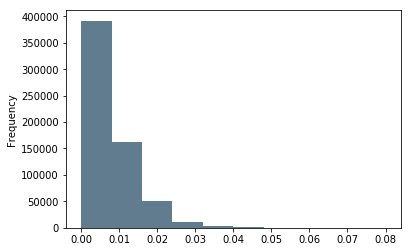

In [78]:
# Check distribution of scores
pd.Series(df['RISK_SCORE']).plot.hist(bins=10, range=(0,0.08) ,color='#607c8e')

In [79]:
df["TIME_DECISION_DATE"] = pd.to_datetime(df["TIME_DECISION_DATE"],format ='%d-%m-%y')

df["MONTH"]= df["TIME_DECISION_DATE"].dt.strftime("%y-%m")

In [80]:
df_summ = df.groupby("MONTH").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

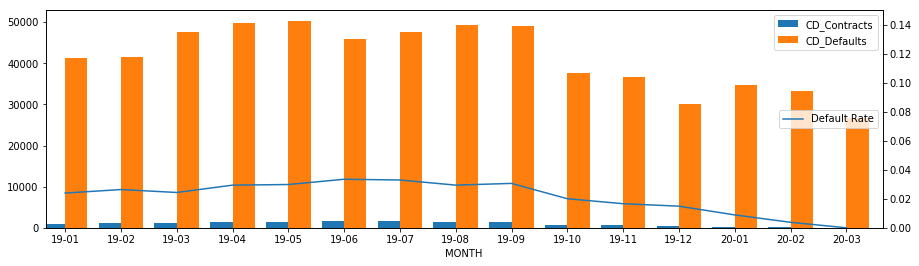

In [81]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [82]:
df["DATE_1"] = pd.to_datetime(df["DATE_1"],format ='%d-%m-%y')
df["DATE_2"] = pd.to_datetime(df["DATE_2"],format ='%d-%m-%y')
df["DATE_3"] = pd.to_datetime(df["DATE_3"],format ='%d-%m-%y')
df["DATE_4"] = pd.to_datetime(df["DATE_4"],format ='%d-%m-%y')
df["DATE_5"] = pd.to_datetime(df["DATE_5"],format ='%d-%m-%y')
df["DATE_6"] = pd.to_datetime(df["DATE_6"],format ='%d-%m-%y')

In [83]:
#Tenure Variables 
df["TENURE1"] = (df["TIME_DECISION_DATE"]-df["DATE_1"]).dt.days
df["TENURE2"] = (df["TIME_DECISION_DATE"]-df["DATE_2"]).dt.days
df["TENURE3"] = (df["TIME_DECISION_DATE"]-df["DATE_3"]).dt.days
df["TENURE4"] = (df["TIME_DECISION_DATE"]-df["DATE_4"]).dt.days
df["TENURE5"] = (df["TIME_DECISION_DATE"]-df["DATE_5"]).dt.days
df["TENURE6"] = (df["TIME_DECISION_DATE"]-df["DATE_6"]).dt.days




In [84]:
#One Hot Encoding
df_encoded = df
for x in ["CODE_1","CODE_2","CODE_3","CODE_4","CODE_5","CODE_6",'REASON_1_ENCODED', 'REASON_2_ENCODED',
       'REASON_3_ENCODED', 'REASON_4_ENCODED', 'REASON_5_ENCODED',
       'REASON_6_ENCODED']:
    
    dummy = pd.get_dummies(df_encoded[x])
    dummy.columns = [y+"_"+x for y in dummy.columns]
    df_encoded = pd.concat([df_encoded, dummy], axis=1)

In [85]:
df = df_encoded

In [86]:
x_column = ['AMT_DIRECT_DEBIT_STATEMENT','TENURE1', 'TENURE2', 'TENURE3', 'TENURE4',
       'TENURE5', 'TENURE6', 'Debited_CODE_1', 'Posted_CODE_1',
       'Undebited_CODE_1', 'Debited_CODE_2', 'Posted_CODE_2',
       'Undebited_CODE_2', 'Debited_CODE_3', 'Posted_CODE_3',
       'Undebited_CODE_3', 'Debited_CODE_4', 'Posted_CODE_4',
       'Undebited_CODE_4', 'Debited_CODE_5', 'Posted_CODE_5',
       'Undebited_CODE_5', 'Debited_CODE_6', 'Posted_CODE_6',
       'Undebited_CODE_6', 'DEBITED_REASON_1_ENCODED',
       'Others_REASON_1_ENCODED', 'PROCESS ISSUE_REASON_1_ENCODED',
       'WILLFULL DEFAULTS_REASON_1_ENCODED', 'DEBITED_REASON_2_ENCODED',
       'Others_REASON_2_ENCODED', 'PROCESS ISSUE_REASON_2_ENCODED',
       'WILLFULL DEFAULTS_REASON_2_ENCODED', 'DEBITED_REASON_3_ENCODED',
       'Others_REASON_3_ENCODED', 'PROCESS ISSUE_REASON_3_ENCODED',
       'WILLFULL DEFAULTS_REASON_3_ENCODED', 'DEBITED_REASON_4_ENCODED',
       'Others_REASON_4_ENCODED', 'PROCESS ISSUE_REASON_4_ENCODED',
       'WILLFULL DEFAULTS_REASON_4_ENCODED', 'DEBITED_REASON_5_ENCODED',
       'Others_REASON_5_ENCODED', 'PROCESS ISSUE_REASON_5_ENCODED',
       'WILLFULL DEFAULTS_REASON_5_ENCODED', 'DEBITED_REASON_6_ENCODED',
       'Others_REASON_6_ENCODED', 'PROCESS ISSUE_REASON_6_ENCODED',
       'WILLFULL DEFAULTS_REASON_6_ENCODED','RISK_SCORE']
y_column = 'RISK_FSTQPD30'

In [87]:
selected_vars = [['AMT_DIRECT_DEBIT_STATEMENT',
  'TENURE6',
  'TENURE5',
  'TENURE2',
  'TENURE3',
  'TENURE1',
  'TENURE4',
  'WILLFULL DEFAULTS_REASON_1_ENCODED',
  'DEBITED_REASON_4_ENCODED',
  'Undebited_CODE_1',
  'Undebited_CODE_2',
  'DEBITED_REASON_2_ENCODED',
  'DEBITED_REASON_6_ENCODED',
  'WILLFULL DEFAULTS_REASON_3_ENCODED']]

In [88]:
## read the model 
# pickle.dump(bst, open(os.getcwd()+r"\model_clx_skp_client", "wb"))
bst = pickle.load(open(os.getcwd()+r"\model_clx_skp_client", 'rb'))


In [89]:
df["XGB_SCORE"] = bst.predict_proba(df[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]

In [99]:
sns.set_style("white")

initial = df[df["TIME_DECISION_DATE"]<pd.datetime(2020,1,1)]["XGB_SCORE"]
new = df[df["TIME_DECISION_DATE"]>=pd.datetime(2020,1,1)]["XGB_SCORE"]

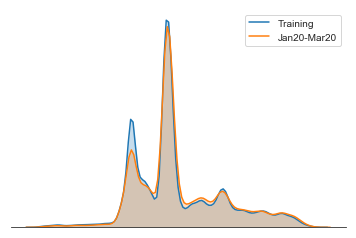

In [103]:
plot = sns.kdeplot(initial, shade=True, label = 'Training')
plot = sns.kdeplot(new, shade=True, label = 'Jan20-Mar20')
plot.set(yticklabels=[], xticklabels = [])
sns.despine(left=True)

In [104]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

buckets = 10
raw_breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
breakpoints = scale_range(raw_breakpoints, np.min(initial), np.max(initial))

In [105]:
initial_counts = np.histogram(initial, breakpoints)[0]
new_counts = np.histogram(new, breakpoints)[0]

In [106]:
df = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Training Count':initial_counts, 'Jan20-Mar20 Count':new_counts})
df['Training Percent'] = df['Training Count'] / len(initial)
df['Jan20-Mar20 Percent'] = df['Jan20-Mar20 Count'] / len(new)

In [108]:
df['Jan20-Mar20 Percent'][df['Jan20-Mar20 Percent'] == 0] = 0.001

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [109]:
df

,Bucket,Breakpoint Value,Training Count,Jan20-Mar20 Count,Training Percent,Jan20-Mar20 Percent
0,1,0.420772,3149,411,0.005979,0.004345
1,2,0.435182,4629,638,0.008789,0.006745
2,3,0.449593,8352,1054,0.015858,0.011142
3,4,0.464003,129369,19698,0.245633,0.208240
4,5,0.478413,207953,39367,0.394840,0.416172
5,6,0.492823,47761,9650,0.090684,0.102016
6,7,0.507234,56511,10604,0.107297,0.112101
7,8,0.521644,32012,6116,0.060781,0.064656
8,9,0.536054,27690,5077,0.052575,0.053672
9,10,0.550464,9251,1978,0.017565,0.020911


In [113]:
percents = df[['Training Percent', 'Jan20-Mar20 Percent', 'Bucket']] \
             .melt(id_vars=['Bucket']) \
             .rename(columns={'variable':'Population', 'value':'Percent'})

In [114]:
percents.head()

,Bucket,Population,Percent
0,1,Training Percent,0.005979
1,2,Training Percent,0.008789
2,3,Training Percent,0.015858
3,4,Training Percent,0.245633
4,5,Training Percent,0.394840


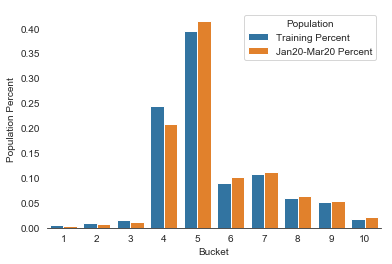

In [115]:
p = sns.barplot(x="Bucket", y="Percent", hue="Population", data=percents)
p.set(xlabel='Bucket', ylabel='Population Percent')
sns.despine(left=True)

In [117]:
df['PSI'] = (df['Jan20-Mar20 Percent'] - df['Training Percent']) * np.log(df['Jan20-Mar20 Percent'] / df['Training Percent'])

In [120]:
df

,Bucket,Breakpoint Value,Training Count,Jan20-Mar20 Count,Training Percent,Jan20-Mar20 Percent,PSI
0,1,0.420772,3149,411,0.005979,0.004345,0.000522
1,2,0.435182,4629,638,0.008789,0.006745,0.000541
2,3,0.449593,8352,1054,0.015858,0.011142,0.001664
3,4,0.464003,129369,19698,0.245633,0.208240,0.006175
4,5,0.478413,207953,39367,0.394840,0.416172,0.001123
5,6,0.492823,47761,9650,0.090684,0.102016,0.001334
6,7,0.507234,56511,10604,0.107297,0.112101,0.000210
7,8,0.521644,32012,6116,0.060781,0.064656,0.000239
8,9,0.536054,27690,5077,0.052575,0.053672,0.000023
9,10,0.550464,9251,1978,0.017565,0.020911,0.000583


In [119]:
np.sum(df['PSI'])

0.012415245129143824